<a href="https://colab.research.google.com/github/nadyavirianta/MachineLearning/blob/master/ML_Machine_Translation_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#IMPORT LIBRARY YG DIGUNAKAN 

import tensorflow as tf
import numpy as np
import math
import os
import pandas as pd
import string
import re
import io
import time
import unicodedata
from numpy import array, argmax, random, take

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, Embedding, RepeatVector, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

## Load Data

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
base_path = "/gdrive/My Drive/CS/"

In [0]:
def load_doc(filename):
	file = open(filename, mode='r', encoding='utf-8')
	text = file.read()
	file.close()
	return text

#split ke sentence
def to_sentences(doc):
	return doc.strip().split('\n')

#kalimat yang paling pendek dan panjang
def sentence_lengths(sentences):
	lengths = [len(s.split()) for s in sentences]
	return min(lengths), max(lengths)

In [0]:
de = base_path + 'news-commentary-v8.de-en.de'
doc_de = load_doc(de)
source = to_sentences(doc_de)
minlen, maxlen = sentence_lengths(source)
print('Deutsch data: sentences=%d, min=%d, max=%d' % (len(source), minlen, maxlen))
 

en = base_path +'news-commentary-v8.de-en.en'
doc_en = load_doc(en)
dest = to_sentences(doc_en)
minlend, maxlend = sentence_lengths(dest)
print('English data: sentences=%d, min=%d, max=%d' % (len(dest), minlend, maxlend))

Deutsch data: sentences=178793, min=0, max=193
English data: sentences=179011, min=0, max=171


In [0]:
#Menggunakan sebagian data
de = source[:2000]
eng = dest[:2000]

###Preprocess

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    #casefolding
    w = unicode_to_ascii(w.lower().strip())

    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # menghilangkan simbol2 kecuali (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()
    return w

In [0]:
for i in range(len(de)):
    de[i] = preprocess_sentence(de[i])
    eng[i] = preprocess_sentence(eng[i])

In [0]:
#Contoh setelah di preprocess
print(de[-1])
print(eng[-1])

das ergebnis sind gro e handelsungleichgewichte zwischen den eurolandern , ein problem , das durch gro e haushaltsdefizite und hohe staatsverschuldung in sudeuropa und frankreich gro enteils gegenuber auslandischen kreditgebern noch verscharft wird .
the result has been large trade imbalances between eurozone countries , a problem compounded by large fiscal deficits and high levels of public debt in southern europe and france much of it owed to foreign creditors .


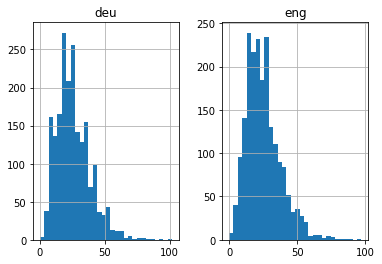

In [0]:
#panjang kalimat
eng_l = []
de_l = []

for i in de:
      de_l.append(len(i.split()))

for j in eng:
      eng_l.append(len(j.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':de_l})

length_df.hist(bins = 30)
plt.show()

In [0]:
#Kalimat terpanjang
length_df.max()

eng     97
deu    102
dtype: int64

In [0]:
#TOKENIZER
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [0]:
# english tokenizer
eng_tokenizer = tokenization(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = length_df.max()[0]
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6716


In [0]:
#german tokenizer
deu_tokenizer = tokenization(de)
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = length_df.max()[1]
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 9733


In [0]:
#untuk encode sentence
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [0]:
#data english and german in pairs
de_eng = np.column_stack((de,eng))

## Model Neural Network

In [0]:
## Split data
from sklearn.model_selection import train_test_split

train, test = train_test_split(de_eng, test_size=0.1, random_state = 12)

In [0]:
#Data untuk training
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 0])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 1])

#Data untuk testing
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 0])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 1])

In [0]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

### LSTM

In [0]:
def define_model_LSTM(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [0]:
# model compilation
model = define_model_LSTM(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 256)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 102, 512)          4983296   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 97, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 97, 512)           2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 97, 6716)          3445308   
Total params: 12,627,004
Trainable params: 12,627,004
Non-trainable params: 0
_________________________________________________________________


In [0]:
filename = base_path + 'modellstm.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
time_callback = TimeHistory()

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=256, validation_split = 0.2, callbacks=[checkpoint, time_callback],
                    verbose=1)


times = time_callback.times

Train on 1440 samples, validate on 360 samples
Epoch 1/30
1440/1440 [==============================] - 95s 66ms/step - loss: 2.2863 - val_loss: 2.1540

Epoch 00001: val_loss improved from inf to 2.15403, saving model to /gdrive/My Drive/CS/modellstm.h5
Epoch 2/30
1440/1440 [==============================] - 95s 66ms/step - loss: 2.1566 - val_loss: 2.1045

Epoch 00002: val_loss improved from 2.15403 to 2.10454, saving model to /gdrive/My Drive/CS/modellstm.h5
Epoch 3/30
1440/1440 [==============================] - 95s 66ms/step - loss: 2.1071 - val_loss: 2.1430

Epoch 00003: val_loss did not improve from 2.10454
Epoch 4/30
1440/1440 [==============================] - 95s 66ms/step - loss: 2.1243 - val_loss: 2.0853

Epoch 00004: val_loss improved from 2.10454 to 2.08525, saving model to /gdrive/My Drive/CS/modellstm.h5
Epoch 5/30
1440/1440 [==============================] - 95s 66ms/step - loss: 2.0765 - val_loss: 2.4683

Epoch 00005: val_loss did not improve from 2.08525
Epoch 6/30
1440

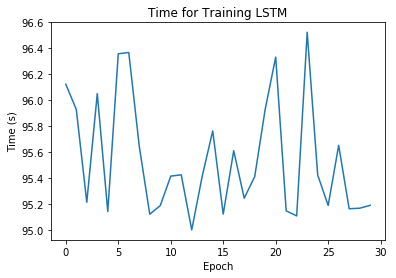

In [0]:
### Waktu training
plt.plot(times)
plt.title('Time for Training LSTM')
plt.ylabel("Time (s)")
plt.xlabel("Epoch")
plt.show()

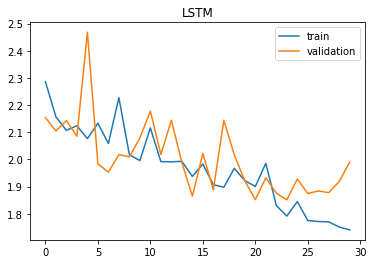

In [0]:
### loss function
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.title('LSTM')
plt.show()

### GRU

In [0]:
def define_model_GRU(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(GRU(units))
      model.add(RepeatVector(out_timesteps))
      model.add(GRU(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [0]:
modelgru = define_model_GRU(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 256)
rms = optimizers.RMSprop(lr=0.001)
modelgru.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

modelgru.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 102, 256)          2491648   
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               393984    
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 97, 256)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 97, 256)           393984    
_________________________________________________________________
dense_4 (Dense)              (None, 97, 6716)          1726012   
Total params: 5,005,628
Trainable params: 5,005,628
Non-trainable params: 0
_________________________________________________________________


In [0]:
filename = base_path + 'modelgru.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
time_callbackgru = TimeHistory()

# train model
historygru = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=256, validation_split = 0.2, callbacks=[checkpoint, time_callbackgru],
                    verbose=1)


timesgru = time_callbackgru.times

Train on 1440 samples, validate on 360 samples
Epoch 1/30
1440/1440 [==============================] - 96s 67ms/step - loss: 1.7517 - val_loss: 1.9450

Epoch 00001: val_loss improved from inf to 1.94504, saving model to /gdrive/My Drive/CS/modelgru.h5
Epoch 2/30
1440/1440 [==============================] - 96s 66ms/step - loss: 1.7465 - val_loss: 1.9788

Epoch 00002: val_loss did not improve from 1.94504
Epoch 3/30
1440/1440 [==============================] - 95s 66ms/step - loss: 1.7377 - val_loss: 1.9877

Epoch 00003: val_loss did not improve from 1.94504
Epoch 4/30
1440/1440 [==============================] - 95s 66ms/step - loss: 1.7246 - val_loss: 1.9252

Epoch 00004: val_loss improved from 1.94504 to 1.92521, saving model to /gdrive/My Drive/CS/modelgru.h5
Epoch 5/30
1440/1440 [==============================] - 95s 66ms/step - loss: 1.7173 - val_loss: 1.8973

Epoch 00005: val_loss improved from 1.92521 to 1.89731, saving model to /gdrive/My Drive/CS/modelgru.h5
Epoch 6/30
1440/14

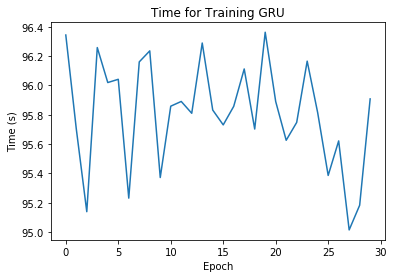

In [0]:
### Waktu training
plt.plot(timesgru)
plt.title('Time for Training GRU')
plt.ylabel("Time (s)")
plt.xlabel("Epoch")
plt.show()

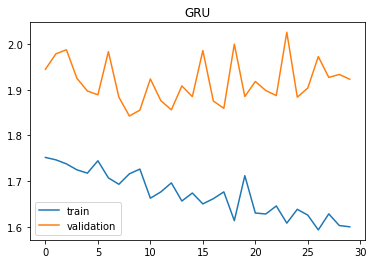

In [0]:
# Loss function
plt.plot(historygru.history['loss'])
plt.plot(historygru.history['val_loss'])
plt.legend(['train','validation'])
plt.title('GRU')
plt.show()

## Evaluasi

In [0]:
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

In [0]:
def evaluate_model(model, tokenizer, sources, raw_dataset):
  actual, predicted = list(), list()
  for i, source in enumerate(sources):
		# translate encoded source text
    source = source.reshape((1, source.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, source)
    raw_src,raw_target = raw_dataset[i]
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
    actual.append([raw_target.split()])
    predicted.append(translation.split())
    asli.append(raw_target)
    pred.append(translation)
	# calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

### LSTM

In [0]:
asli, pred = list(), list()
evaluate_model(model, deu_tokenizer, testX, test)

src=[wir haben im rahmen unserer analyse z . b . die vorteile untersucht , die sich kurzfristig aus starker zielgerichteten strategien ergeben wurden dem kauf muckenresistenter moskitonetze und oraler malariamedikamente zur rehydration von kindern in den armsten vom klimawandel betroffenen landern .], target=[our analysis investigated , for example , the merits of more targeted policies for the near term purchasing mosquito resistant bed nets and oral re hydration malaria therapy for children in the poorest nations affected by climate change .], predicted=[the the the the the the the the the the the the the the the the the the the the the the the the the the the]
src=[new york ist dies das zeitalter der verschworungstheorien ?], target=[new york is this the age of the conspiracy theory ?], predicted=[the the is is the the the]
src=[ein defizitabbau durch einschnitte bei der finanzierung von bildung , infrastruktur und forschung und entwicklung ahnelt dem versuch , abzunehmen , indem ma

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
pred_df_lstm = pd.DataFrame({'actual' : asli, 'predicted' : pred})
pred_df_lstm.to_csv(base_path + 'hasillstm.csv')

In [0]:
pred_df_lstm.tail()

,actual,predicted
195,"over six days , about , flights were canceled ...",the the the the the the the the the the the th...
196,"on the contrary , a shakeout of less productiv...",the the the the the the the the the the the th...
197,success in peacefully removing a tyrant has se...,the the the the the the the the the the the th...
198,"some people are very trusting of others , and ...",the the the the the the the the the the the th...
199,other feedback loops pose a similar danger .,the the the is the the the


### GRU

In [0]:
asli, pred = list(), list()
evaluate_model(modelgru, deu_tokenizer, testX, test)

src=[wir haben im rahmen unserer analyse z . b . die vorteile untersucht , die sich kurzfristig aus starker zielgerichteten strategien ergeben wurden dem kauf muckenresistenter moskitonetze und oraler malariamedikamente zur rehydration von kindern in den armsten vom klimawandel betroffenen landern .], target=[our analysis investigated , for example , the merits of more targeted policies for the near term purchasing mosquito resistant bed nets and oral re hydration malaria therapy for children in the poorest nations affected by climate change .], predicted=[recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent recent rec

In [0]:
pred_df_gru = pd.DataFrame({'actual' : asli, 'predicted' : pred})
pred_df_gru.to_csv(base_path + 'hasilgru.csv')

In [0]:
pred_df_gru


,actual,predicted
0,"our analysis investigated , for example , the ...",recent recent recent recent recent recent rece...
1,new york is this the age of the conspiracy the...,severe severe severe severe severe acceptable ...
2,reducing the deficit by cutting funds for educ...,normandy normandy normandy normandy normandy n...
3,"a number of countries , including denmark , th...",tentative references references references sol...
4,"by contrast , the military had earlier publicl...",get get get get get get get get get get get ge...
5,"precisely for this reason , it also requires a...",nuclear nuclear nuclear nuclear nuclear cbo cb...
6,that plugged part of the loophole in the treat...,renewed renewed renewed renewed renewed renewe...
7,"instead , the immediate focus needs to be on b...",inet inet inet inet inet inet inet inet inet i...
8,but there was no evidence that the more widely...,trotsky trotsky trotsky trotsky trotsky trotsk...
9,allowing countries to pursue their own policie...,acknowledging acknowledging logic logic logic ...
